#LeNet-5 

In [ ]:
import torch
#To allow the use of autograd
from torch.autograd import Variable 

#Import MNIST of handwritten digits dataset
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

#Plot
import random
import matplotlib.pyplot as plt

##Model

In [ ]:
#Model
class LeNet_5(torch.nn.Module):

    def __init__(self, nof_classes):
        #Heritage from nn.Module
        super(LeNet_5, self).__init__()

        #Features extractor part
        self.feat_extractor_part = torch.nn.Sequential(
            #Conv2D
            torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=1, stride=1, bias=True),
            torch.nn.ReLU(),
            #Sub-Sampling (average pooling)
            torch.nn.AvgPool2d(kernel_size=(2,2), stride=2, padding=0),
            #Conv2D
            torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=(5,5), padding=0, stride=1, bias=True),
            torch.nn.ReLU(),
            #Sub-Sampling (average pooling)
            torch.nn.AvgPool2d(kernel_size=(2,2), stride=2, padding=1),
            #Conv2D
            torch.nn.Conv2d(in_channels=16, out_channels=120, kernel_size=(5,5), padding=0, stride=1, bias=True),
            torch.nn.ReLU(),
        )

        self.classification_part = torch.nn.Sequential(
            #Fully connected
            torch.nn.Linear(in_features=120, out_features=84),
            torch.nn.ReLU(),
            torch.nn.Linear(in_features=84, out_features=nof_classes),
            torch.nn.Softmax(),
        )

    def forward(self, x):

        #Extractor
        x = self.feat_extractor_part(x)
        #Reshape
        x = torch.flatten(x, 1)
        #Classification
        x = self.classification_part(x)
        
        return x



##Utils

In [ ]:
def saveModel(model, file_path):
    """
        Function to save model's parameters
    """
    torch.save(model.state_dict(), file_path)


def loadModel(model, file_path, device):
    """
        Function to load function when only the params have been saved
    """
    params = torch.load(file_path)
    model.load_state_dict(params)


def checkPoint_model(model, 
                     optimizer, loss, epoch,
                     file_path):
    """
        Function to save model's checkpoints
    """
    
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': loss}, 
                file_path)

def load_checkPoint_model(model, optimizer, file_path, device):

    checkpoint = torch.load(file_path)

    #Loading
    model.load_state_dict(checkpoint['model_state_dict'], map_location=device)
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'], map_location=device)
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']

    return epoch, loss


def train_model(model, train_loader, test_loader, 
                nof_epochs, optimizer, learning_rate, criterion, 
                file_path_save_model):

    #Which device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")

    # Convert and send model parameters and buffers to GPU 
    model.to(device)

    best_accuracy = 0.0

    for epoch in range(nof_epochs):

        epoch_loss     = 0.0
        epoch_accuracy = 0.0

        #Training
        for i, (images, labels) in enumerate(train_loader, 0):
        
            #Data send to device + requires_grad=True
            images, labels = Variable(images.to(device)), Variable(labels.to(device))

            #Zero the gradient 
            optimizer.zero_grad()
            #Predictions 
            labels_hat = model(images)
            #Loss
            epoch_loss = criterion(labels_hat, labels)
            #Upgrade the gradients (backpropagate) and the optimizer
            epoch_loss.backward()
            optimizer.step()

        #Accuracy
        nof_predictions = 0.0

        #Evaluation of the model (model.eval() fasten the inference)
        model.eval()

        #Fasten the inference by setting every requires_grad to False
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                #Run the model on the test set
                outputs = model(images)
                #Extract the labels with the maximum probability
                _, labels_hat = torch.max(outputs.data, 1)
                nof_predictions += labels.size(0)
                epoch_accuracy += (labels_hat == labels).sum().item()
        #Compute the accuracy over the test set
        epoch_accuracy = (100*epoch_accuracy/nof_predictions)

        print('Epoch', epoch+1,', test accuracy: {:.4f} % \n'.format(epoch_accuracy))
        
        #Save model when best accuracy is beaten
        if epoch_accuracy > best_accuracy:
            saveModel(model, file_path_save_model)
            best_accuracy = epoch_accuracy

    return model


def plot_inference(model, dataset):

    fig = plt.figure(figsize=(10,10))
    nof_images = len(dataset.data)

    for i in range(20):

        #Select a random image in the dataset
        idx = random.randrange(nof_images)
        #Inference
        label = dataset[idx][1]
        image = dataset[idx][0].unsqueeze(0).to(device)
        #print(image.shape)
        with torch.no_grad():
            model.eval()
            label_hat = torch.max(model(image), 1).indices[0].item()
            #print(torch.max(model(image), 1).indices[0].item())
        #Sent back the image to the CPU
        image = image.squeeze().to('cpu')

        #Plot
        ax = plt.subplot(5,4,i+1)
        ax.set_title("predicted label = {}".format(label_hat))
        plt.imshow(image, cmap='gray_r')
        plt.axis('off')
    
    fig.suptitle("{}'s predictions on few examples".format(model.__class__.__name__), fontsize=16)

    #Save
    plt.savefig(str(model.__class__.__name__) + "_accuraccy_97.1" + ".pdf")

    #Show
    plt.show()



def displayConvFilers(model, 
                      layer_name,
                      optimizer, epoch,
                      figsize=(2,2),
                      ):

    layer = model.state_dict()[layer_name]
    batch, channels, height, width = layer.shape
    nof_filters = batch*channels

    fig = plt.figure(figsize=figsize)

    for b_idx in range(batch):
        for c_idx in range(channels):

            #Get the filter on the batch n°b_idx on the channel n°c_idx
            filter = layer[b_idx][c_idx].cpu()
            #Filter is number i in the subplot
            i = b_idx*channels + c_idx

            ax = plt.subplot(batch, channels, i+1)
            plt.imshow(filter, cmap='gray')

            #Layout of the subplots
            #Withdraw ticks
            ax.set_yticks([])
            ax.set_xticks([])
            if (c_idx==0):
                ax.set_ylabel("Batch #{}".format(b_idx+1), fontsize=20)
            #Display the number of channel at the bottom of the figure
            if b_idx == (batch - 1):
                ax.set_xlabel("Channel #{}".format(c_idx+1), fontsize=20)

    #Layout of the figure
    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    fig.suptitle("Visualization of layer's filters on {} model (unpruned)\n".format(model.__class__.__name__) 
              + "(Model characteristics - optimizer: {}, learning rate: {}, number of epochs: {})\n \n".format(optimizer.__class__.__name__, 
                                                                                                               optimizer.state_dict()['param_groups'][0]['lr'],
                                                                                                               str(epoch)) 
              + "Layer name: {}, Filters' size: ({}x{})".format(layer_name, 
                                                                height, width)
             , fontsize=25)

    #Save figure
    plt.savefig(str(model.__class__.__name__) + "_" + layer_name + "_" 
                + "batch_" + str(batch) + "_" 
                + "channels_" + str(channels)  + "_" 
                + "height" + str(height) + "_" 
                + "width_" + str(width)  
                + ".pdf"
                )
    
    #Show figure
    plt.show()

##Main

In [ ]:
from torchsummary import summary

In [ ]:
if __name__ == "__main__":

    #If model need to been trained turn train to True and load to False
    train = True
    #If model need to be loaded from a pth file, turn train to False and load to True
    load = False

    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    #Model
    nof_classes = 10
    LeNet5 = LeNet_5(nof_classes)

    #Summary
    #summary(LeNet5, (1, 28, 28))

    ###Import the dataset###
    transform = transforms.Compose([transforms.CenterCrop(28),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=0.5, std=0.5)
                                    ])
    #Train dataset
    mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    #Dataloader used to shuffle and create batch
    train_loader   = torch.utils.data.DataLoader(mnist_trainset, batch_size=32, shuffle=True)
    #Test dataset
    mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader   = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=True)

    #Hyper parameters
    nof_epochs = 10
    lr = 0.0001
    optimizer = torch.optim.Adam(LeNet5.parameters(), lr)
    criterion = torch.nn.CrossEntropyLoss()

    #File's path to save the parameters of the model
    file_path='/content/LeNet5_params.pt'

    #Train
    if train:
        LeNet5 = train_model(model=LeNet5, train_loader=train_loader, test_loader=test_loader, 
                            nof_epochs=nof_epochs, optimizer=optimizer, learning_rate=lr, criterion=criterion, 
                            file_path_save_model=file_path)
    
    if load:
        #Saving the model params
        file_path='/content/LeNet5_params.pt'
        saveModel(LeNet5, file_path)

        #Loading the model
        file_path='/content/LeNet5_params.pt'
        loadModel(LeNet5, file_path, device)

        #Sending model to GPU
        LeNet5.to(device)

The model will be running on cuda:0 device


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch 1 , test accuracy: 82.8200 % 

Epoch 2 , test accuracy: 83.9900 % 

Epoch 3 , test accuracy: 85.3800 % 

Epoch 4 , test accuracy: 93.4900 % 

Epoch 5 , test accuracy: 94.8200 % 

Epoch 6 , test accuracy: 95.4100 % 

Epoch 7 , test accuracy: 96.1800 % 

Epoch 8 , test accuracy: 96.4500 % 

Epoch 9 , test accuracy: 96.8700 % 

Epoch 10 , test accuracy: 96.4400 % 



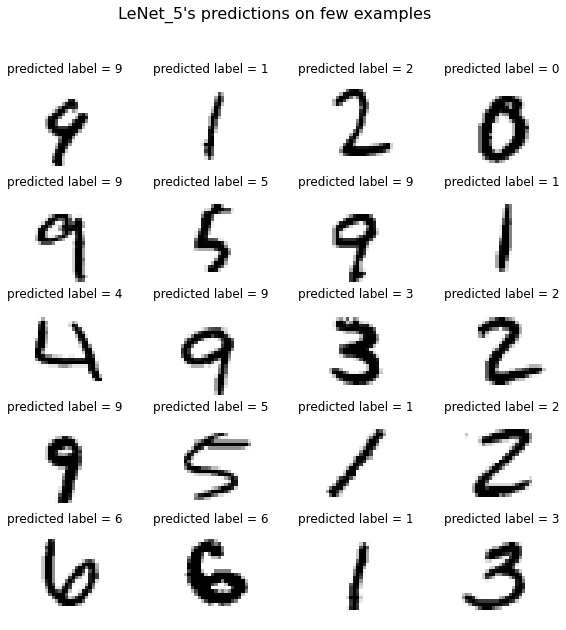

In [ ]:
plot_inference(LeNet5, mnist_testset)

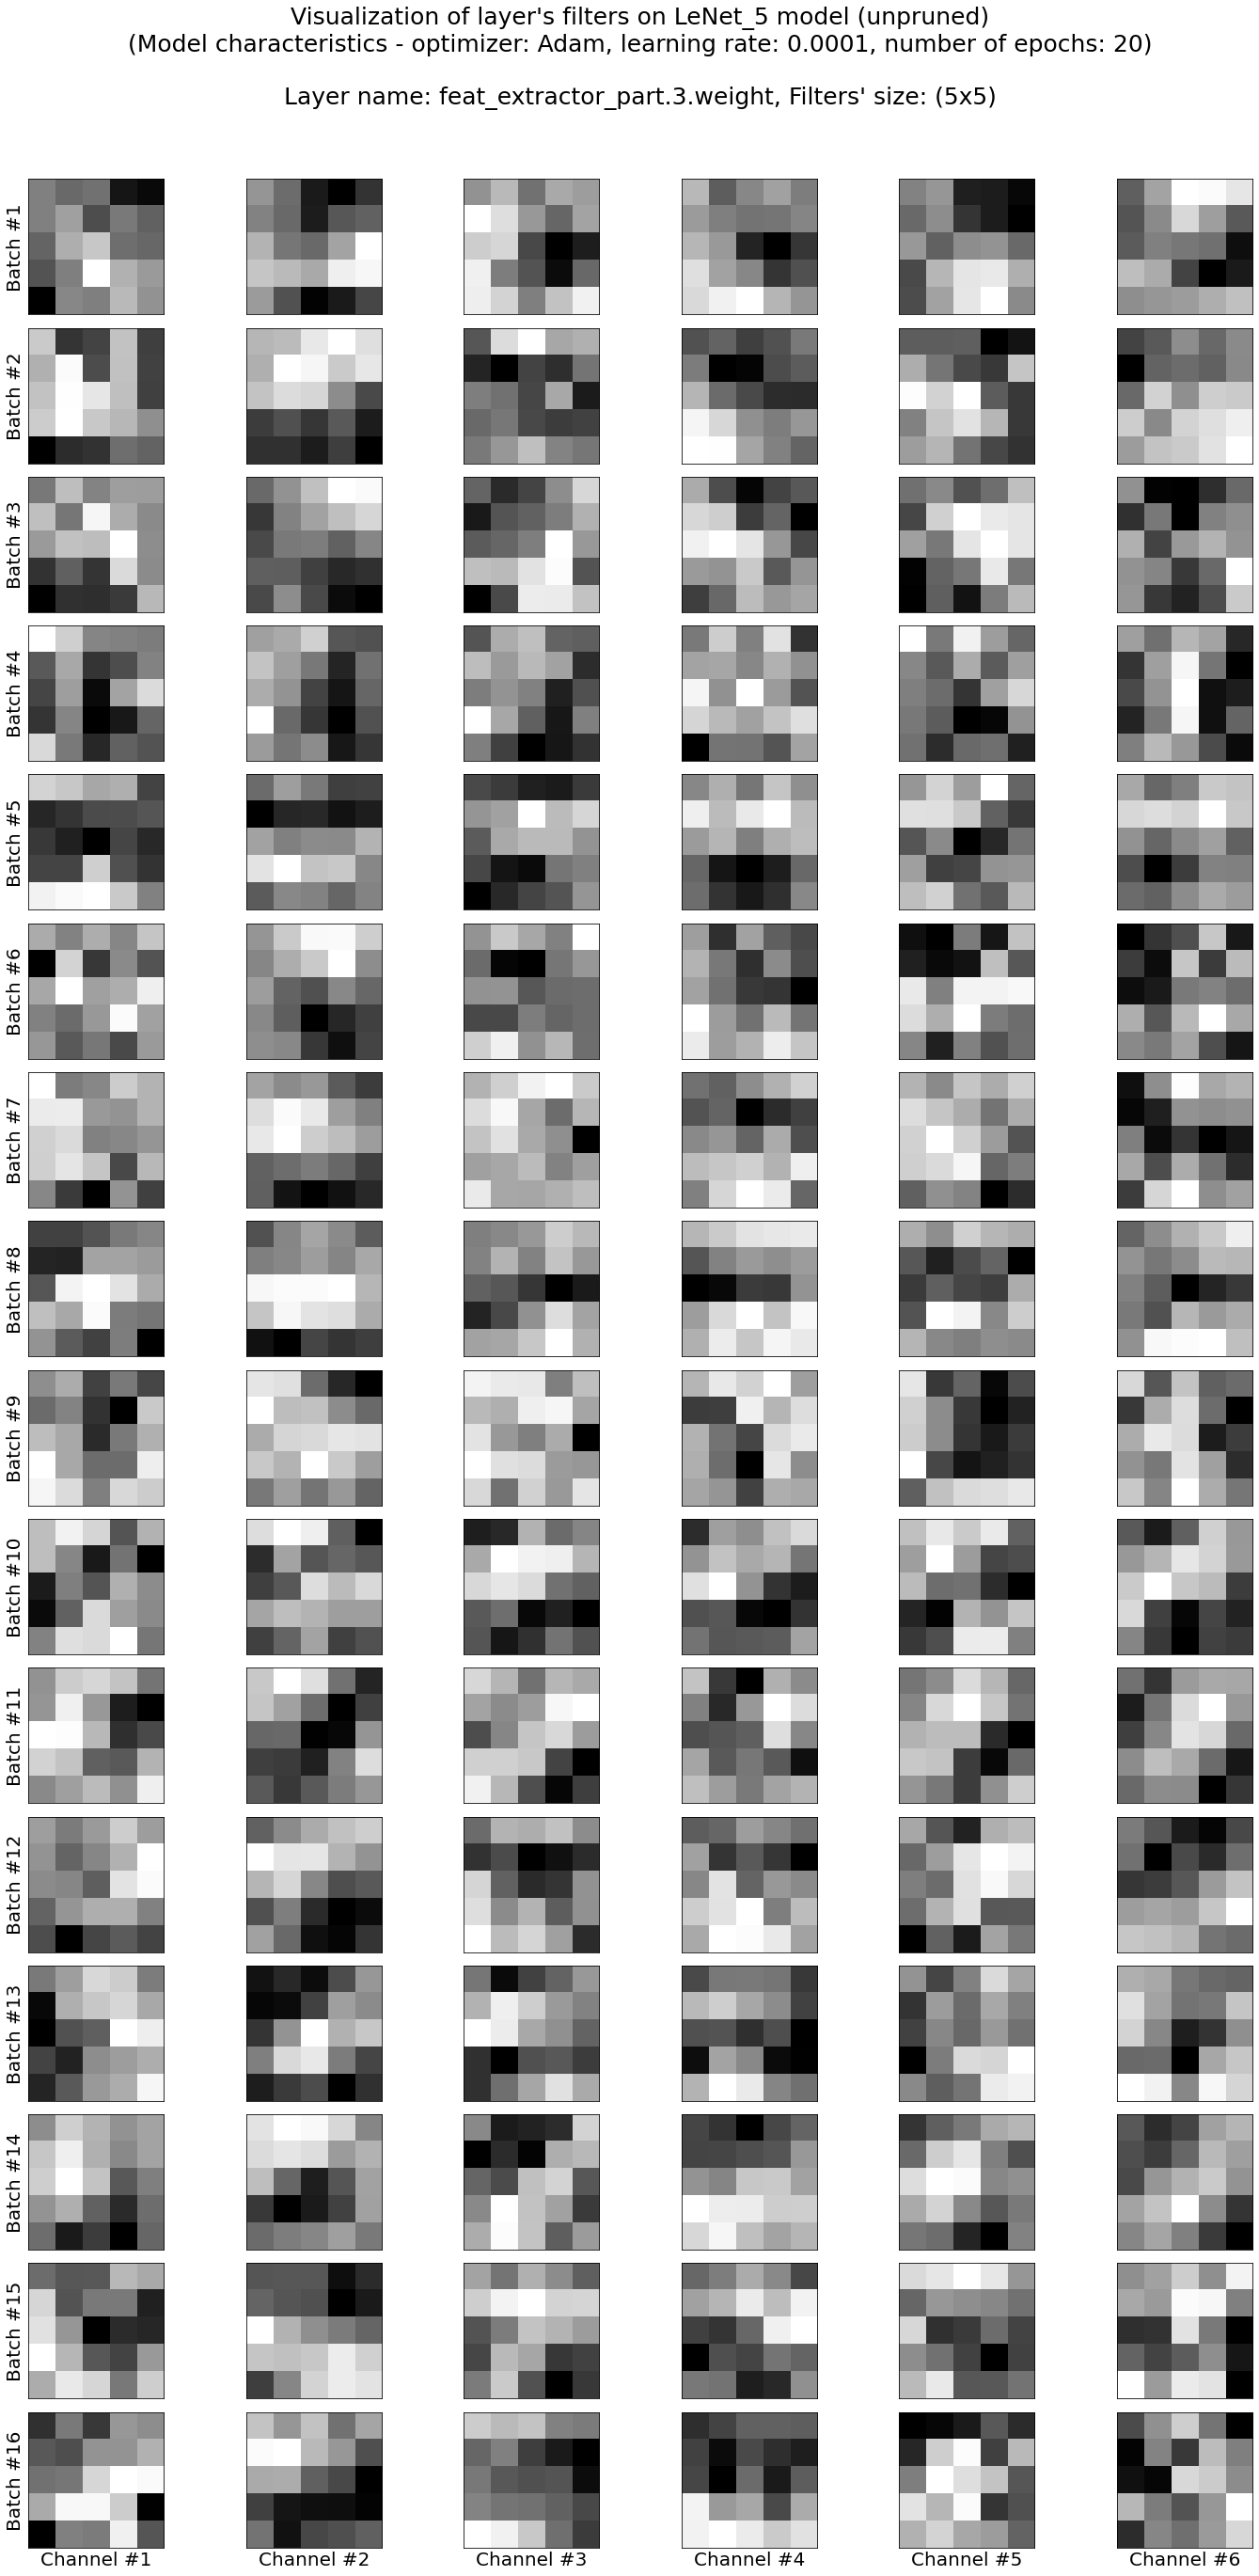

In [ ]:
layer_name = "feat_extractor_part.3.weight"
figsize    = (20,40)
model      = LeNet5
nof_epochs = 20

displayConvFilers(model, 
                  layer_name, optimizer, nof_epochs,
                  figsize)